In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
league_list = pd.read_csv('league_lookups.csv')

In [3]:
league_list

,Country Code,Country Name,League Name,League Code
0,EN,England,Premier League,E0
1,SC,Scotland,Scottish Premier League,SC0
2,DE,Germany,Bundesliga,D1
3,IT,Italy,Serie A,I1
4,ES,Spain,Primera Division,SP1
5,FR,France,Ligue A,F1
6,NL,Netherlands,Eredevisie,N1
7,BE,Belgium,Jupiler League,B1
8,PT,Portugal,Liga I,P1
9,GR,Greece,Superleague,G1


In [4]:
data_url = 'https://www.football-data.co.uk/mmz4281/'

Download and store historical data: 

In [5]:
start_season = '2009-2010'

current_year = pd.to_datetime('today').year
current_month = pd.to_datetime('today').month
current_season = str(current_year) + '-' + str(current_year+1) if current_month > 6 else str(current_year-1) + '-' + str(current_year) 

seasons = [start_season]
for i in range(0,int(current_season[:4])-int(start_season[:4])):
    seasons.append(str(int(start_season[:4])+(i+1)) + '-' + str(int(start_season[:4])+(i+2)))

seasons                  

['2009-2010',
 '2010-2011',
 '2011-2012',
 '2012-2013',
 '2013-2014',
 '2014-2015',
 '2015-2016',
 '2016-2017',
 '2017-2018',
 '2018-2019',
 '2019-2020',
 '2020-2021',
 '2021-2022']

In [ ]:
data = pd.DataFrame()
for season in seasons:
    season_code = season[2:4]+season[7:9]
    for league_code in league_list['League Code']:
        csv_url = data_url+season_code+'/'+league_code+'.csv'
        data_season_league = pd.read_csv(csv_url, encoding='iso-8859-1')
        data_season_league['Season'] = season_code
        data = data.append(data_season_league)
        
data.insert(0, "Season", data.pop('Season'))

data_historical = data[~pd.isna(data['FTR'])]
data_historical = data_historical.loc[:,~data_historical.columns.str.contains('^Unnamed')]

data_historical.to_csv('data_historical.csv',index=False)

Download latest data:

In [5]:
current_year = pd.to_datetime('today').year
current_month = pd.to_datetime('today').month
current_season = str(current_year) + '-' + str(current_year+1) if current_month > 6 else str(current_year-1) + '-' + str(current_year) 

In [6]:
latest_data = pd.DataFrame()

season_code = current_season[2:4]+current_season[7:9]
for league_code in league_list['League Code']:
    csv_url = data_url+season_code+'/'+league_code+'.csv'
    data_season_league = pd.read_csv(csv_url, encoding='iso-8859-1')
    data_season_league['Season'] = season_code
    latest_data = latest_data.append(data_season_league)

latest_data.insert(0, "Season", latest_data.pop('Season'))

new_fixtures = latest_data[pd.isna(latest_data['FTR'])].dropna()
print('{} upcoming fixtures found.'.format(len(new_fixtures)))

# Add latest historical datat o existing historical data
latest_historical = latest_data[~pd.isna(latest_data['FTR'])]
data_historical = pd.read_csv('data_historical.csv')
prev_records = len(data_historical)
data_historical = data_historical.append(latest_historical).drop_duplicates(subset=['Date','HomeTeam','AwayTeam'])
new_records = len(data_historical)
print('{} records added.'.format(new_records-prev_records))
data_historical.to_csv('data_historical.csv',index=False)

0 upcoming fixtures found.


C:\Users\akapelet\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (66,80) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0 records added.


In [7]:
data_historical.tail()

,Season,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,Unnamed: 105
38884,2122,P1,19/12/2021,Sp Braga,Belenenses,1.0,0.0,H,1.0,0.0,...,-1.75,1.89,2.01,1.90,1.99,2.04,2.03,1.88,1.98,NaN
38885,2122,G1,18/12/2021,Panetolikos,Atromitos,2.0,1.0,H,1.0,0.0,...,-0.25,1.80,2.05,1.84,2.02,1.92,2.12,1.83,1.99,NaN
38886,2122,G1,19/12/2021,Olympiakos,Lamia,1.0,0.0,H,1.0,0.0,...,-2.00,1.95,1.90,1.98,1.85,2.10,1.94,1.98,1.84,NaN
38887,2122,G1,19/12/2021,Panathinaikos,Giannina,2.0,0.0,H,0.0,0.0,...,-0.75,1.77,2.10,1.73,2.15,1.87,2.16,1.81,2.02,NaN
38888,2122,G1,19/12/2021,PAOK,Asteras Tripolis,3.0,2.0,H,1.0,1.0,...,-0.75,1.80,2.05,1.79,2.08,1.88,2.13,1.82,2.00,NaN


In [8]:
data_historical = data_historical.append(new_fixtures) # add new fixtures at the bottom of the historical table so that pre-match statistics are also calculated for the new fixtures 

### Calculate prediction features

In [139]:
data_historical = pd.read_csv('data_historical.csv')

C:\Users\akapelet\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (66,80) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [140]:
data_historical['Date'] = data_historical['Date'].apply(lambda x: x[:x.rfind('/')+1] + '20' + x[x.rfind('/')+1:] if len(x[x.rfind('/')+1:])==2 else x) 
data_historical['Date'] = pd.to_datetime(data_historical['Date'],format='%d/%m/%Y')

Points, Goals before each match:

In [142]:
# Betting odds data
betting_odds = data_historical[['Season','Div','Date','HomeTeam','AwayTeam','B365H','B365A','B365D','FTR']]
betting_odds.loc[:,'B365_Pred'] = betting_odds[['B365H','B365A','B365D']].apply(lambda x: ['H','A','D'][np.argmin(x)],axis=1)
betting_odds.loc[:,'B365H_Prob'] = betting_odds[['B365H','B365A','B365D']].apply(lambda x: (1/x[0])/(1/x[0]+1/x[1]+1/x[2]),axis=1)
betting_odds.loc[:,'B365A_Prob'] = betting_odds[['B365H','B365A','B365D']].apply(lambda x: (1/x[1])/(1/x[0]+1/x[1]+1/x[2]),axis=1)
betting_odds.loc[:,'B365D_Prob'] = betting_odds[['B365H','B365A','B365D']].apply(lambda x: (1/x[2])/(1/x[0]+1/x[1]+1/x[2]),axis=1)

betting_odds = betting_odds.rename(columns={'FTR':'Result_Actual'})

C:\Users\akapelet\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [11]:
# Match points
data_historical['H_Match_Points'] = data_historical['FTR'].apply(lambda x: 3 if x=='H' else 1 if x=='D' else 0) 
data_historical['A_Match_Points'] = data_historical['FTR'].apply(lambda x: 3 if x=='A' else 1 if x=='D' else 0)

In [13]:
# Points before match
data_historical = data_historical.sort_values(by='Date')
H_team_stats = data_historical[['HomeTeam','Season','Div','Date','AwayTeam','H_Match_Points','FTHG','FTAG']]
H_team_stats = H_team_stats.rename(columns={'HomeTeam':'Team', 'AwayTeam':'Opponent'})

H_team_stats['H/A'] = 'H'

H_team_stats['H_Points_Season'] = H_team_stats.groupby(['Team','Season'])['H_Match_Points'].cumsum()
H_team_stats['H_Points_Pre_Match_Season'] = H_team_stats['H_Points_Season']-H_team_stats['H_Match_Points']

H_team_stats['H_Points'] = H_team_stats.groupby(['Team'])['H_Match_Points'].cumsum()
H_team_stats['H_Points_Pre_Match'] = H_team_stats['H_Points']-H_team_stats['H_Match_Points']

H_team_stats['Goals_Scored'] = H_team_stats['FTHG']
H_team_stats['Goals_Conceded'] = H_team_stats['FTAG']

H_team_stats['H_Goals_Scored'] = H_team_stats.groupby(['Team','Season'])['FTHG'].cumsum()
H_team_stats['H_Goals_Conceded'] = H_team_stats.groupby(['Team','Season'])['FTAG'].cumsum()

H_team_stats['N_Home_Matches'] = H_team_stats.groupby(['Team'])['Team'].cumcount() + 1

In [14]:
A_team_stats = data_historical[['AwayTeam','Season','Div','Date','HomeTeam','A_Match_Points','FTHG','FTAG']]
A_team_stats = A_team_stats.rename(columns={'AwayTeam':'Team', 'HomeTeam':'Opponent'})

A_team_stats['H/A'] = 'A'

A_team_stats['A_Points_Season'] = A_team_stats.groupby(['Team','Season'])['A_Match_Points'].cumsum()
A_team_stats['A_Points_Pre_Match_Season'] = A_team_stats['A_Points_Season']-A_team_stats['A_Match_Points']

A_team_stats['A_Points'] = A_team_stats.groupby(['Team'])['A_Match_Points'].cumsum()
A_team_stats['A_Points_Pre_Match'] = A_team_stats['A_Points']-A_team_stats['A_Match_Points']

A_team_stats['Goals_Scored'] = A_team_stats['FTAG']
A_team_stats['Goals_Conceded'] = A_team_stats['FTHG']

A_team_stats['A_Goals_Scored'] = A_team_stats.groupby(['Team','Season'])['FTAG'].cumsum()
A_team_stats['A_Goals_Conceded'] = A_team_stats.groupby(['Team','Season'])['FTHG'].cumsum()

A_team_stats['N_Away_Matches'] = A_team_stats.groupby(['Team'])['Team'].cumcount() + 1

In [15]:
team_stats = H_team_stats.append(A_team_stats)

In [16]:
team_stats['Match_Points'] = team_stats['H_Match_Points'].fillna(0) + team_stats['A_Match_Points'].fillna(0)

In [17]:
team_stats = team_stats.sort_values(by='Date')

team_stats['Total_Points_Season'] = team_stats.groupby(['Team','Season'])['Match_Points'].cumsum()
team_stats['Total_Points_Pre_Match_Season'] = team_stats['Total_Points_Season'] - team_stats['Match_Points']

team_stats['Total_Points'] = team_stats.groupby(['Team'])['Match_Points'].cumsum()
team_stats['Total_Points_Pre_Match'] = team_stats['Total_Points'] - team_stats['Match_Points']

team_stats['Total_Goals_Scored'] = team_stats.groupby(['Team','Season'])['Goals_Scored'].cumsum()
team_stats['Total_Goals_Conceded'] = team_stats.groupby(['Team','Season'])['Goals_Conceded'].cumsum()

team_stats['Total_Goals_Scored_Pre_Match'] = team_stats.groupby(['Team','Season'])['Goals_Scored'].cumsum() - team_stats['Goals_Scored']
team_stats['Total_Goals_Conceded_Pre_Match'] = team_stats.groupby(['Team','Season'])['Goals_Conceded'].cumsum() - team_stats['Goals_Conceded']

team_stats['N_Matches_Season'] = team_stats.groupby(['Team','Season'])['Team'].cumcount() + 1
team_stats['N_Matches'] = team_stats.groupby(['Team'])['Team'].cumcount() + 1

In [18]:
team_stats[(team_stats['Team']=='Olympiakos')&(team_stats['Season']==2122)].to_csv('check1.csv',index=False)
team_stats[(team_stats['Team']=='Olympiakos')&(team_stats['Season']==2122)]

,Team,Season,Div,Date,Opponent,H_Match_Points,FTHG,FTAG,H/A,H_Points_Season,...,Total_Points_Season,Total_Points_Pre_Match_Season,Total_Points,Total_Points_Pre_Match,Total_Goals_Scored,Total_Goals_Conceded,Total_Goals_Scored_Pre_Match,Total_Goals_Conceded_Pre_Match,N_Matches_Season,N_Matches
38353,Olympiakos,2122,G1,2021-09-12,Atromitos,1.0,0.0,0.0,H,1.0,...,1.0,0.0,917.0,916.0,0.0,0.0,0.0,0.0,1,380
38361,Olympiakos,2122,G1,2021-09-19,Lamia,NaN,1.0,2.0,A,NaN,...,4.0,1.0,920.0,917.0,2.0,1.0,0.0,0.0,2,381
38363,Olympiakos,2122,G1,2021-09-22,Apollon,3.0,4.0,1.0,H,4.0,...,7.0,4.0,923.0,920.0,6.0,2.0,2.0,1.0,3,382
38369,Olympiakos,2122,G1,2021-09-26,Asteras Tripolis,NaN,0.0,2.0,A,NaN,...,10.0,7.0,926.0,923.0,8.0,2.0,6.0,2.0,4,383
38382,Olympiakos,2122,G1,2021-10-03,Panathinaikos,1.0,0.0,0.0,H,5.0,...,11.0,10.0,927.0,926.0,8.0,2.0,8.0,2.0,5,384
38388,Olympiakos,2122,G1,2021-10-17,Giannina,NaN,1.0,2.0,A,NaN,...,14.0,11.0,930.0,927.0,10.0,3.0,8.0,2.0,6,385
38396,Olympiakos,2122,G1,2021-10-24,PAOK,3.0,2.0,1.0,H,8.0,...,17.0,14.0,933.0,930.0,12.0,4.0,10.0,3.0,7,386
38397,Olympiakos,2122,G1,2021-10-30,Panetolikos,NaN,1.0,2.0,A,NaN,...,20.0,17.0,936.0,933.0,14.0,5.0,12.0,4.0,8,387
38409,Olympiakos,2122,G1,2021-11-07,Ionikos,3.0,1.0,0.0,H,11.0,...,23.0,20.0,939.0,936.0,15.0,5.0,14.0,5.0,9,388
38680,Olympiakos,2122,G1,2021-11-21,AEK,NaN,2.0,3.0,A,NaN,...,26.0,23.0,942.0,939.0,18.0,7.0,15.0,5.0,10,389


In [19]:
# Points won on last n games (H/A and total)
def calc_last_games_points(stats, n_last, index_columns):
    
    n_last_str = str(n_last)
    
    # Last n Home game
    stats['N_Home_Matches_PLUS_' + n_last_str] = stats['N_Home_Matches'] + n_last
    stats = stats.merge(stats[stats['N_Home_Matches'].notna()][index_columns + ['N_Home_Matches_PLUS_' + n_last_str,'H_Points_Pre_Match']].rename(columns={'H_Points_Pre_Match':'H_Points_Pre_' + n_last_str}),left_on=index_columns+['N_Home_Matches'],right_on=index_columns+['N_Home_Matches_PLUS_' + n_last_str], how='left')
    stats['H_Points_Pre_' + n_last_str] = stats['H_Points_Pre_Match']-stats['H_Points_Pre_' + n_last_str]
    stats['Last_'+ n_last_str + '_H'] = stats['H_Points_Pre_'+ n_last_str] / (3*n_last)
    stats = stats.drop(columns=['N_Home_Matches_PLUS_' + n_last_str + '_x','N_Home_Matches_PLUS_' + n_last_str + '_y'])
    stats = stats.drop_duplicates()

    # Last n Away game
    stats['N_Away_Matches_PLUS_' + n_last_str] = stats['N_Away_Matches'] + n_last
    stats = stats.merge(stats[stats['N_Away_Matches'].notna()][index_columns+['N_Away_Matches_PLUS_' + n_last_str,'A_Points_Pre_Match']].rename(columns={'A_Points_Pre_Match':'A_Points_Pre_' + n_last_str}),left_on=index_columns+['N_Away_Matches'],right_on=index_columns+['N_Away_Matches_PLUS_' + n_last_str], how='left')
    stats['A_Points_Pre_' + n_last_str] = stats['A_Points_Pre_Match']-stats['A_Points_Pre_' + n_last_str]
    stats['Last_'+ n_last_str + '_A'] = stats['A_Points_Pre_'+ n_last_str] / (3*n_last)
    stats = stats.drop(columns=['N_Away_Matches_PLUS_' + n_last_str + '_x','N_Away_Matches_PLUS_' + n_last_str + '_y'])
    stats = stats.drop_duplicates()

    # Last n games (Home or Away)
    stats['N_Matches_PLUS_' + n_last_str] = stats['N_Matches'] + n_last
    stats = stats.merge(stats[stats['N_Matches'].notna()][index_columns+['N_Matches_PLUS_' + n_last_str,'Total_Points_Pre_Match']].rename(columns={'Total_Points_Pre_Match':'Total_Points_Pre_' + n_last_str}),left_on=index_columns+['N_Matches'],right_on=index_columns+['N_Matches_PLUS_' + n_last_str], how='left')
    stats['Total_Points_Pre_' + n_last_str] = stats['Total_Points_Pre_Match']-stats['Total_Points_Pre_' + n_last_str]
    stats['Last_'+ n_last_str] = stats['Total_Points_Pre_'+ n_last_str] / (3*n_last)
    stats = stats.drop(columns=['N_Matches_PLUS_' + n_last_str + '_x','N_Matches_PLUS_' + n_last_str + '_y'])
    stats = stats.drop_duplicates()
    
    return stats

In [20]:
index_columns = ['Team']
team_stats = calc_last_games_points(team_stats, n_last = 1, index_columns = index_columns)
team_stats = calc_last_games_points(team_stats, n_last = 3, index_columns = index_columns)
team_stats = calc_last_games_points(team_stats, n_last = 5, index_columns = index_columns)

In [21]:
print('Last 1 game home points stats -  Min: {}, Max: {}'.format(team_stats['Last_1_H'].min(),team_stats['Last_1_H'].max()))
print('Last 1 game away points stats -  Min: {}, Max: {}'.format(team_stats['Last_1_A'].min(),team_stats['Last_1_A'].max()))
print('Last 1 game total points stats -  Min: {}, Max: {}'.format(team_stats['Last_1'].min(),team_stats['Last_1'].max()))

print('Last 3 game home points stats -  Min: {}, Max: {}'.format(team_stats['Last_3_H'].min(),team_stats['Last_3_H'].max()))
print('Last 3 game away points stats -  Min: {}, Max: {}'.format(team_stats['Last_3_A'].min(),team_stats['Last_3_A'].max()))
print('Last 3 game total points stats -  Min: {}, Max: {}'.format(team_stats['Last_3'].min(),team_stats['Last_3'].max()))

print('Last 5 game home points stats -  Min: {}, Max: {}'.format(team_stats['Last_5_H'].min(),team_stats['Last_5_H'].max()))
print('Last 5 game away points stats -  Min: {}, Max: {}'.format(team_stats['Last_5_A'].min(),team_stats['Last_5_A'].max()))
print('Last 5 game total points stats -  Min: {}, Max: {}'.format(team_stats['Last_5'].min(),team_stats['Last_5'].max()))

Last 1 game home points stats -  Min: 0.0, Max: 1.0
Last 1 game away points stats -  Min: 0.0, Max: 1.0
Last 1 game total points stats -  Min: 0.0, Max: 1.0
Last 3 game home points stats -  Min: 0.0, Max: 1.0
Last 3 game away points stats -  Min: 0.0, Max: 1.0
Last 3 game total points stats -  Min: 0.0, Max: 1.0
Last 5 game home points stats -  Min: 0.0, Max: 1.0
Last 5 game away points stats -  Min: 0.0, Max: 1.0
Last 5 game total points stats -  Min: 0.0, Max: 1.0


In [22]:
# For check
team_stats[(team_stats['Div']=='G1')&(team_stats['Season']==2122)].to_csv('test_1.csv',index=False)

History of results between each team pair

In [23]:
opponent_history = team_stats[['Team','Opponent','H/A','Date','H_Match_Points','A_Match_Points','Match_Points']].copy()

In [24]:
opponent_history['N_Home_Matches'] = opponent_history.groupby(['Team','Opponent','H/A']).cumcount()+1
opponent_history.loc[opponent_history['H/A']=='A','N_Home_Matches'] = np.nan
opponent_history['N_Away_Matches'] = opponent_history.groupby(['Team','Opponent','H/A']).cumcount()+1
opponent_history.loc[opponent_history['H/A']=='H','N_Away_Matches'] = np.nan
opponent_history['N_Matches'] = opponent_history.groupby(['Team','Opponent']).cumcount()+1

In [25]:
opponent_history['H_Points'] = opponent_history.groupby(['Team','Opponent','H/A'])['H_Match_Points'].cumsum()
opponent_history['H_Points_Pre_Match'] = opponent_history['H_Points']-opponent_history['H_Match_Points']
opponent_history['A_Points'] = opponent_history.groupby(['Team','Opponent','H/A'])['A_Match_Points'].cumsum()
opponent_history['A_Points_Pre_Match'] = opponent_history['A_Points']-opponent_history['A_Match_Points']
opponent_history['Total_Points'] = opponent_history.groupby(['Team','Opponent'])['Match_Points'].cumsum()
opponent_history['Total_Points_Pre_Match'] = opponent_history['Total_Points'] - opponent_history['Match_Points']

In [26]:
index_columns = ['Team','Opponent']
opponent_history = calc_last_games_points(opponent_history, n_last = 1, index_columns = index_columns)
opponent_history = calc_last_games_points(opponent_history, n_last = 3, index_columns = index_columns)
opponent_history = calc_last_games_points(opponent_history, n_last = 5, index_columns = index_columns)

In [27]:
opponent_history[(opponent_history['Team']=='Olympiakos')&(opponent_history['Opponent']=='AEK')]

,Team,Opponent,H/A,Date,H_Match_Points,A_Match_Points,Match_Points,N_Home_Matches,N_Away_Matches,N_Matches,...,A_Points_Pre_3,Last_3_A,Total_Points_Pre_3,Last_3,H_Points_Pre_5,Last_5_H,A_Points_Pre_5,Last_5_A,Total_Points_Pre_5,Last_5
928,Olympiakos,AEK,A,2009-09-23,NaN,3.0,3.0,NaN,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3014,Olympiakos,AEK,H,2010-01-06,0.0,NaN,0.0,1.0,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8459,Olympiakos,AEK,A,2010-11-27,NaN,0.0,0.0,NaN,2.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11060,Olympiakos,AEK,H,2011-03-20,3.0,NaN,3.0,2.0,NaN,4,...,NaN,NaN,3.0,0.333333,NaN,NaN,NaN,NaN,NaN,NaN
13529,Olympiakos,AEK,A,2011-10-15,NaN,1.0,1.0,NaN,3.0,5,...,NaN,NaN,3.0,0.333333,NaN,NaN,NaN,NaN,NaN,NaN
16003,Olympiakos,AEK,H,2012-02-10,3.0,NaN,3.0,3.0,NaN,6,...,NaN,NaN,4.0,0.444444,NaN,NaN,NaN,NaN,7.0,0.466667
20376,Olympiakos,AEK,A,2012-11-11,NaN,3.0,3.0,NaN,4.0,7,...,4.0,0.444444,7.0,0.777778,NaN,NaN,NaN,NaN,7.0,0.466667
23128,Olympiakos,AEK,H,2013-03-10,3.0,NaN,3.0,4.0,NaN,8,...,NaN,NaN,7.0,0.777778,NaN,NaN,NaN,NaN,10.0,0.666667
38724,Olympiakos,AEK,H,2015-10-17,3.0,NaN,3.0,5.0,NaN,9,...,NaN,NaN,9.0,1.000000,NaN,NaN,NaN,NaN,13.0,0.866667
41429,Olympiakos,AEK,A,2016-02-13,NaN,0.0,0.0,NaN,5.0,10,...,4.0,0.444444,9.0,1.000000,NaN,NaN,NaN,NaN,13.0,0.866667


In [28]:
opponent_history[(opponent_history['Team']=='Olympiakos')&(opponent_history['Opponent']=='AEK')].to_csv('check_2.csv',index=False)

In [29]:
print('Last 1 game home points stats -  Min: {}, Max: {}'.format(opponent_history['Last_1_H'].min(),opponent_history['Last_1_H'].max()))
print('Last 1 game away points stats -  Min: {}, Max: {}'.format(opponent_history['Last_1_A'].min(),opponent_history['Last_1_A'].max()))
print('Last 1 game total points stats -  Min: {}, Max: {}'.format(opponent_history['Last_1'].min(),opponent_history['Last_1'].max()))

print('Last 3 game home points stats -  Min: {}, Max: {}'.format(opponent_history['Last_3_H'].min(),opponent_history['Last_3_H'].max()))
print('Last 3 game away points stats -  Min: {}, Max: {}'.format(opponent_history['Last_3_A'].min(),opponent_history['Last_3_A'].max()))
print('Last 3 game total points stats -  Min: {}, Max: {}'.format(opponent_history['Last_3'].min(),opponent_history['Last_3'].max()))

print('Last 5 game home points stats -  Min: {}, Max: {}'.format(opponent_history['Last_5_H'].min(),opponent_history['Last_5_H'].max()))
print('Last 5 game away points stats -  Min: {}, Max: {}'.format(opponent_history['Last_5_A'].min(),opponent_history['Last_5_A'].max()))
print('Last 5 game total points stats -  Min: {}, Max: {}'.format(opponent_history['Last_5'].min(),opponent_history['Last_5'].max()))

Last 1 game home points stats -  Min: 0.0, Max: 1.0
Last 1 game away points stats -  Min: 0.0, Max: 1.0
Last 1 game total points stats -  Min: 0.0, Max: 1.0
Last 3 game home points stats -  Min: 0.0, Max: 1.0
Last 3 game away points stats -  Min: 0.0, Max: 1.0
Last 3 game total points stats -  Min: 0.0, Max: 1.0
Last 5 game home points stats -  Min: 0.0, Max: 1.0
Last 5 game away points stats -  Min: 0.0, Max: 1.0
Last 5 game total points stats -  Min: 0.0, Max: 1.0


In [30]:
opponent_history.columns

Index(['Team', 'Opponent', 'H/A', 'Date', 'H_Match_Points', 'A_Match_Points',
       'Match_Points', 'N_Home_Matches', 'N_Away_Matches', 'N_Matches',
       'H_Points', 'H_Points_Pre_Match', 'A_Points', 'A_Points_Pre_Match',
       'Total_Points', 'Total_Points_Pre_Match', 'H_Points_Pre_1', 'Last_1_H',
       'A_Points_Pre_1', 'Last_1_A', 'Total_Points_Pre_1', 'Last_1',
       'H_Points_Pre_3', 'Last_3_H', 'A_Points_Pre_3', 'Last_3_A',
       'Total_Points_Pre_3', 'Last_3', 'H_Points_Pre_5', 'Last_5_H',
       'A_Points_Pre_5', 'Last_5_A', 'Total_Points_Pre_5', 'Last_5'],
      dtype='object')

In [31]:
opponent_history = opponent_history.rename(columns={'Last_1_H':'Last_1_H_Teams','Last_1_A':'Last_1_A_Teams','Last_1':'Last_1_Teams',
                                                    'Last_3_H':'Last_3_H_Teams','Last_3_A':'Last_3_A_Teams','Last_3':'Last_3_Teams',
                                                    'Last_5_H':'Last_5_H_Teams','Last_5_A':'Last_5_A_Teams','Last_5':'Last_5_Teams'}

                                          )

opponent_history = opponent_history[['Team','Date','Last_1_H_Teams','Last_1_A_Teams','Last_1_Teams',
                 'Last_3_H_Teams','Last_3_A_Teams','Last_3_Teams',
                 'Last_5_H_Teams','Last_5_A_Teams','Last_5_Teams']]

League standings

In [32]:
standings = pd.DataFrame(team_stats.groupby(['Team','Season','Div','N_Matches_Season'])['Total_Points_Pre_Match_Season'].sum())
standings['Standing_Pre_Match'] = standings.groupby(['Div','Season','N_Matches_Season'])['Total_Points_Pre_Match_Season'].rank('dense',ascending=False)
standings = standings.reset_index(level=[0,1,2,3])

In [33]:
standings[(standings['Div']=='E0')&(standings['Season']==2122)].sort_values(by=['N_Matches_Season','Standing_Pre_Match']).tail(18)

,Team,Season,Div,N_Matches_Season,Total_Points_Pre_Match_Season,Standing_Pre_Match
15864,Chelsea,2122,E0,17,36.0,3.0
75581,West Ham,2122,E0,17,28.0,4.0
4283,Arsenal,2122,E0,17,26.0,5.0
76930,Wolves,2122,E0,17,21.0,6.0
5035,Aston Villa,2122,E0,17,19.0,7.0
17117,Crystal Palace,2122,E0,17,19.0,7.0
21340,Everton,2122,E0,17,18.0,8.0
36102,Leeds,2122,E0,17,16.0,9.0
62756,Southampton,2122,E0,17,16.0,9.0
48449,Newcastle,2122,E0,17,10.0,10.0


Combine pre-match statistics

In [34]:
team_stats.columns

Index(['Team', 'Season', 'Div', 'Date', 'Opponent', 'H_Match_Points', 'FTHG',
       'FTAG', 'H/A', 'H_Points_Season', 'H_Points_Pre_Match_Season',
       'H_Points', 'H_Points_Pre_Match', 'Goals_Scored', 'Goals_Conceded',
       'H_Goals_Scored', 'H_Goals_Conceded', 'N_Home_Matches',
       'A_Match_Points', 'A_Points_Season', 'A_Points_Pre_Match_Season',
       'A_Points', 'A_Points_Pre_Match', 'A_Goals_Scored', 'A_Goals_Conceded',
       'N_Away_Matches', 'Match_Points', 'Total_Points_Season',
       'Total_Points_Pre_Match_Season', 'Total_Points',
       'Total_Points_Pre_Match', 'Total_Goals_Scored', 'Total_Goals_Conceded',
       'Total_Goals_Scored_Pre_Match', 'Total_Goals_Conceded_Pre_Match',
       'N_Matches_Season', 'N_Matches', 'H_Points_Pre_1', 'Last_1_H',
       'A_Points_Pre_1', 'Last_1_A', 'Total_Points_Pre_1', 'Last_1',
       'H_Points_Pre_3', 'Last_3_H', 'A_Points_Pre_3', 'Last_3_A',
       'Total_Points_Pre_3', 'Last_3', 'H_Points_Pre_5', 'Last_5_H',
       'A_Point

In [35]:
team_stats = team_stats.drop(columns=['H_Match_Points', 'H_Points', 'H_Points_Pre_Match', 
                                      'H_Points_Season', 'H_Points_Pre_Match_Season', 'N_Home_Matches',
                                      'Goals_Scored', 'Goals_Conceded', 'H_Goals_Scored', 'H_Goals_Conceded',
                                       'A_Match_Points', 'A_Points', 'A_Points_Pre_Match',
                                       'A_Points_Season', 'A_Points_Pre_Match_Season', 'N_Away_Matches',
                                       'Total_Points_Season', 'Total_Points_Pre_Match_Season', 'N_Matches',
                                       'A_Goals_Scored', 'A_Goals_Conceded','Total_Points', 
                                      'Total_Points_Pre_Match', 'Total_Goals_Scored',
                                       'Total_Goals_Conceded', 'Total_Goals_Scored_Pre_Match',
                                       'Total_Goals_Conceded_Pre_Match', 'H_Points_Pre_1',
                                       'A_Points_Pre_1', 'Total_Points_Pre_1','H_Points_Pre_3', 
                                      'A_Points_Pre_3','Total_Points_Pre_3', 'H_Points_Pre_5',
                                       'A_Points_Pre_5', 'Total_Points_Pre_5'])

In [36]:
team_stats.columns

Index(['Team', 'Season', 'Div', 'Date', 'Opponent', 'FTHG', 'FTAG', 'H/A',
       'Match_Points', 'N_Matches_Season', 'Last_1_H', 'Last_1_A', 'Last_1',
       'Last_3_H', 'Last_3_A', 'Last_3', 'Last_5_H', 'Last_5_A', 'Last_5'],
      dtype='object')

In [37]:
team_stats.head()

,Team,Season,Div,Date,Opponent,FTHG,FTAG,H/A,Match_Points,N_Matches_Season,Last_1_H,Last_1_A,Last_1,Last_3_H,Last_3_A,Last_3,Last_5_H,Last_5_A,Last_5
0,Standard,910,B1,2009-07-31,St Truiden,2.0,2.0,H,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Heerenveen,910,N1,2009-07-31,Roda JC,0.0,0.0,H,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Roda JC,910,N1,2009-07-31,Heerenveen,0.0,0.0,A,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,St Truiden,910,B1,2009-07-31,Standard,2.0,2.0,A,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Westerlo,910,B1,2009-08-01,Mechelen,4.0,1.0,A,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
team_stats = team_stats.merge(opponent_history, on=['Team','Date'], how='left')

In [39]:
team_stats = team_stats.merge(standings[['Team','Season','N_Matches_Season','Standing_Pre_Match']], on=['Team','Season','N_Matches_Season'], how='left')
team_stats = team_stats.drop_duplicates()

In [40]:
team_stats.head()

,Team,Season,Div,Date,Opponent,FTHG,FTAG,H/A,Match_Points,N_Matches_Season,...,Last_1_H_Teams,Last_1_A_Teams,Last_1_Teams,Last_3_H_Teams,Last_3_A_Teams,Last_3_Teams,Last_5_H_Teams,Last_5_A_Teams,Last_5_Teams,Standing_Pre_Match
0,Standard,910,B1,2009-07-31,St Truiden,2.0,2.0,H,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,Heerenveen,910,N1,2009-07-31,Roda JC,0.0,0.0,H,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,Roda JC,910,N1,2009-07-31,Heerenveen,0.0,0.0,A,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,St Truiden,910,B1,2009-07-31,Standard,2.0,2.0,A,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,Westerlo,910,B1,2009-08-01,Mechelen,4.0,1.0,A,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [41]:
team_stats.columns

Index(['Team', 'Season', 'Div', 'Date', 'Opponent', 'FTHG', 'FTAG', 'H/A',
       'Match_Points', 'N_Matches_Season', 'Last_1_H', 'Last_1_A', 'Last_1',
       'Last_3_H', 'Last_3_A', 'Last_3', 'Last_5_H', 'Last_5_A', 'Last_5',
       'Last_1_H_Teams', 'Last_1_A_Teams', 'Last_1_Teams', 'Last_3_H_Teams',
       'Last_3_A_Teams', 'Last_3_Teams', 'Last_5_H_Teams', 'Last_5_A_Teams',
       'Last_5_Teams', 'Standing_Pre_Match'],
      dtype='object')

In [42]:
team_stats

,Team,Season,Div,Date,Opponent,FTHG,FTAG,H/A,Match_Points,N_Matches_Season,...,Last_1_H_Teams,Last_1_A_Teams,Last_1_Teams,Last_3_H_Teams,Last_3_A_Teams,Last_3_Teams,Last_5_H_Teams,Last_5_A_Teams,Last_5_Teams,Standing_Pre_Match
0,Standard,910,B1,2009-07-31,St Truiden,2.0,2.0,H,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,Heerenveen,910,N1,2009-07-31,Roda JC,0.0,0.0,H,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,Roda JC,910,N1,2009-07-31,Heerenveen,0.0,0.0,A,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,St Truiden,910,B1,2009-07-31,Standard,2.0,2.0,A,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,Westerlo,910,B1,2009-08-01,Mechelen,4.0,1.0,A,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77773,Go Ahead Eagles,2122,N1,2021-12-19,Nijmegen,0.0,2.0,H,0.0,17,...,0.333333,NaN,1.0,NaN,NaN,0.555556,NaN,NaN,NaN,8.0
77774,Waalwijk,2122,N1,2021-12-19,PSV Eindhoven,1.0,4.0,H,0.0,17,...,0.000000,NaN,0.0,0.333333,NaN,0.000000,0.600000,NaN,0.200000,11.0
77775,Newcastle,2122,E0,2021-12-19,Man City,0.0,4.0,H,0.0,18,...,0.000000,NaN,0.0,0.444444,NaN,0.000000,0.333333,NaN,0.266667,7.0
77776,Cadiz,2122,SP1,2021-12-19,Real Madrid,0.0,0.0,A,1.0,18,...,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0


In [43]:
# Separate historical stats from new fixtures
new_fixture_stats = team_stats[pd.isna(team_stats['FTHG'])].dropna()
historical_team_stats = team_stats[~pd.isna(team_stats['FTHG'])]

historical_team_stats.to_csv('historical_team_stats.csv',index=False)

In [45]:
len(data_historical[pd.isna(data_historical['B365H'])])/len(data_historical)

0.0023399933143048164

When combining team's and opponents stats, probably separate Home and Away games, so that we don't have H & A statistics together in the same columns.

In [46]:
historical_team_stats

,Team,Season,Div,Date,Opponent,FTHG,FTAG,H/A,Match_Points,N_Matches_Season,...,Last_1_H_Teams,Last_1_A_Teams,Last_1_Teams,Last_3_H_Teams,Last_3_A_Teams,Last_3_Teams,Last_5_H_Teams,Last_5_A_Teams,Last_5_Teams,Standing_Pre_Match
0,Standard,910,B1,2009-07-31,St Truiden,2.0,2.0,H,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,Heerenveen,910,N1,2009-07-31,Roda JC,0.0,0.0,H,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,Roda JC,910,N1,2009-07-31,Heerenveen,0.0,0.0,A,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,St Truiden,910,B1,2009-07-31,Standard,2.0,2.0,A,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,Westerlo,910,B1,2009-08-01,Mechelen,4.0,1.0,A,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77773,Go Ahead Eagles,2122,N1,2021-12-19,Nijmegen,0.0,2.0,H,0.0,17,...,0.333333,NaN,1.0,NaN,NaN,0.555556,NaN,NaN,NaN,8.0
77774,Waalwijk,2122,N1,2021-12-19,PSV Eindhoven,1.0,4.0,H,0.0,17,...,0.000000,NaN,0.0,0.333333,NaN,0.000000,0.600000,NaN,0.200000,11.0
77775,Newcastle,2122,E0,2021-12-19,Man City,0.0,4.0,H,0.0,18,...,0.000000,NaN,0.0,0.444444,NaN,0.000000,0.333333,NaN,0.266667,7.0
77776,Cadiz,2122,SP1,2021-12-19,Real Madrid,0.0,0.0,A,1.0,18,...,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0


In [47]:
historical_team_stats.columns

Index(['Team', 'Season', 'Div', 'Date', 'Opponent', 'FTHG', 'FTAG', 'H/A',
       'Match_Points', 'N_Matches_Season', 'Last_1_H', 'Last_1_A', 'Last_1',
       'Last_3_H', 'Last_3_A', 'Last_3', 'Last_5_H', 'Last_5_A', 'Last_5',
       'Last_1_H_Teams', 'Last_1_A_Teams', 'Last_1_Teams', 'Last_3_H_Teams',
       'Last_3_A_Teams', 'Last_3_Teams', 'Last_5_H_Teams', 'Last_5_A_Teams',
       'Last_5_Teams', 'Standing_Pre_Match'],
      dtype='object')

Split into Home and Away matrices and add opponent stats

In [48]:
H_team_stats = historical_team_stats[historical_team_stats['H/A']=='H'].drop(columns=['Last_1_A', 'Last_3_A','Last_5_A','Last_1_A_Teams', 'Last_3_A_Teams','Last_5_A_Teams'])
A_team_stats = historical_team_stats[historical_team_stats['H/A']=='A'].drop(columns=['Last_1_H', 'Last_3_H','Last_5_H','Last_1_H_Teams', 'Last_3_H_Teams','Last_5_H_Teams'])

In [49]:
H_team_stats['Result'] = H_team_stats['Match_Points'].apply(lambda x: 'W' if x==3 else 'D' if x==1 else 'L')
A_team_stats['Result'] = A_team_stats['Match_Points'].apply(lambda x: 'W' if x==3 else 'D' if x==1 else 'L')

In [50]:
# Add opponent data
H_team_stats = H_team_stats.merge(A_team_stats[['Team','Date','Last_1','Last_3','Last_5', 'Last_1_A','Last_3_A','Last_5_A','Standing_Pre_Match']]\
                   .rename(columns={'Last_1':'Last_1_Opp','Last_3':'Last_3_Opp','Last_5':'Last_5_Opp','Last_1_A':'Last_1_A_Opp',\
                                    'Last_3_A':'Last_3_A_Opp','Last_5_A':'Last_5_A_Opp','Standing_Pre_Match':'Standing_Pre_Match_Opp'}),\
                  left_on=['Opponent','Date'],right_on=['Team','Date']).rename(columns={'Team_x':'Team'}).drop(columns=['Team_y'])

In [51]:
# Add opponent data
A_team_stats = A_team_stats.merge(H_team_stats[['Team','Date','Last_1','Last_3','Last_5', 'Last_1_H','Last_3_H','Last_5_H','Standing_Pre_Match']]\
                   .rename(columns={'Last_1':'Last_1_Opp','Last_3':'Last_3_Opp','Last_5':'Last_5_Opp','Last_1_H':'Last_1_H_Opp',\
                                    'Last_3_H':'Last_3_H_Opp','Last_5_H':'Last_5_H_Opp','Standing_Pre_Match':'Standing_Pre_Match_Opp'}),\
                  left_on=['Opponent','Date'],right_on=['Team','Date']).rename(columns={'Team_x':'Team'}).drop(columns=['Team_y'])

In [52]:
H_team_stats['Standing_Pre_Match_vs_Opp'] = H_team_stats['Standing_Pre_Match'] - H_team_stats['Standing_Pre_Match_Opp']
A_team_stats['Standing_Pre_Match_vs_Opp'] = A_team_stats['Standing_Pre_Match'] - A_team_stats['Standing_Pre_Match_Opp']

H_team_stats = H_team_stats.drop(columns=['Standing_Pre_Match_Opp'])
A_team_stats = A_team_stats.drop(columns=['Standing_Pre_Match_Opp'])

In [53]:
H_team_stats.columns

Index(['Team', 'Season', 'Div', 'Date', 'Opponent', 'FTHG', 'FTAG', 'H/A',
       'Match_Points', 'N_Matches_Season', 'Last_1_H', 'Last_1', 'Last_3_H',
       'Last_3', 'Last_5_H', 'Last_5', 'Last_1_H_Teams', 'Last_1_Teams',
       'Last_3_H_Teams', 'Last_3_Teams', 'Last_5_H_Teams', 'Last_5_Teams',
       'Standing_Pre_Match', 'Result', 'Last_1_Opp', 'Last_3_Opp',
       'Last_5_Opp', 'Last_1_A_Opp', 'Last_3_A_Opp', 'Last_5_A_Opp',
       'Standing_Pre_Match_vs_Opp'],
      dtype='object')

Normalise features

All features except Standing_Pre_Match and Standing_Pre_Match_vs_Opp have values between 0 and 1.

In [54]:
# For Standing_Pre_Match divide by total number of teams in each league
H_team_stats = H_team_stats.merge(H_team_stats.groupby(['Div','Season'])['Team'].nunique().rename({'Team':'N_Teams'}),on=['Div','Season']).rename(columns={'Team_x':'Team','Team_y':'N_Teams'})
H_team_stats['Standing_Pre_Match'] = H_team_stats['Standing_Pre_Match']/H_team_stats['N_Teams']
H_team_stats = H_team_stats.drop(columns=['N_Teams'])

A_team_stats = A_team_stats.merge(A_team_stats.groupby(['Div','Season'])['Team'].nunique().rename({'Team':'N_Teams'}),on=['Div','Season']).rename(columns={'Team_x':'Team','Team_y':'N_Teams'})
A_team_stats['Standing_Pre_Match'] = A_team_stats['Standing_Pre_Match']/A_team_stats['N_Teams']
A_team_stats = A_team_stats.drop(columns=['N_Teams'])

In [55]:
# For Standing_Pre_Match_vs_Opp_norm apply min-max normalisation
H_team_stats['Standing_Pre_Match_vs_Opp'] = (H_team_stats['Standing_Pre_Match_vs_Opp']-H_team_stats['Standing_Pre_Match_vs_Opp'].min())/(H_team_stats['Standing_Pre_Match_vs_Opp'].max()-H_team_stats['Standing_Pre_Match_vs_Opp'].min())
A_team_stats['Standing_Pre_Match_vs_Opp'] = (A_team_stats['Standing_Pre_Match_vs_Opp']-A_team_stats['Standing_Pre_Match_vs_Opp'].min())/(A_team_stats['Standing_Pre_Match_vs_Opp'].max()-A_team_stats['Standing_Pre_Match_vs_Opp'].min())

Deal with missing values

In [56]:
print('N/As by columns')
for column in H_team_stats.columns:
    print('{}: {}'.format(column,H_team_stats[column].isna().sum()))

N/As by columns
Team: 0
Season: 0
Div: 0
Date: 0
Opponent: 0
FTHG: 0
FTAG: 0
H/A: 0
Match_Points: 0
N_Matches_Season: 0
Last_1_H: 327
Last_1: 155
Last_3_H: 961
Last_3: 471
Last_5_H: 1595
Last_5: 791
Last_1_H_Teams: 8164
Last_1_Teams: 4162
Last_3_H_Teams: 19477
Last_3_Teams: 11361
Last_5_H_Teams: 26863
Last_5_Teams: 16999
Standing_Pre_Match: 0
Result: 0
Last_1_Opp: 172
Last_3_Opp: 490
Last_5_Opp: 804
Last_1_A_Opp: 317
Last_3_A_Opp: 951
Last_5_A_Opp: 1585
Standing_Pre_Match_vs_Opp: 0


In [57]:
len(H_team_stats.dropna())

12026

Last_5_Teams & Last_5_H_Teams have many N/As so we will drop them. Last_3_Teams & Last_3_H_Teams also have many N/As, but they will provide useful information for records that have a value. To avoid removing too many records, we will replace N/A Last_3_H_Teams & Last_3_Teams with the average values of rows with the same Last_1_H_Teams & Last_1_Teams respectively. The same will be done for Away stats.

In [58]:
def missing_value_av_filling(df, dep_feature, indep_feature):
    
    for value in df[indep_feature].unique():
        if pd.isna(value)==False:
            av_value = np.average(df.loc[(df[indep_feature]==value)&(~pd.isna(df[dep_feature])),dep_feature])
            df.loc[(df[indep_feature]==value)&(pd.isna(df[dep_feature])),dep_feature] = av_value
    
    return df

In [59]:
H_team_stats = H_team_stats.drop(columns=['Last_5_H_Teams','Last_5_Teams'])

# Fill 3 game stats with average of existing 3 game stats with the same 1 game stat 
H_team_stats = missing_value_av_filling(H_team_stats, 'Last_3_H_Teams', 'Last_1_H_Teams')
H_team_stats = missing_value_av_filling(H_team_stats, 'Last_3_Teams', 'Last_1_Teams')

# Alternative: directly use 1 game stats for 3 stats
# H_team_stats.loc[pd.isna(H_team_stats['Last_3_H_Teams']),'Last_3_H_Teams'] = H_team_stats['Last_1_H_Teams']
# H_team_stats.loc[pd.isna(H_team_stats['Last_3_Teams']),'Last_3_Teams'] = H_team_stats['Last_1_Teams']

In [60]:
len(H_team_stats.dropna())

30725

In [61]:
H_team_stats = H_team_stats.dropna().reset_index(drop=True)

In [62]:
len(A_team_stats.dropna())

12026

In [63]:
A_team_stats.columns

Index(['Team', 'Season', 'Div', 'Date', 'Opponent', 'FTHG', 'FTAG', 'H/A',
       'Match_Points', 'N_Matches_Season', 'Last_1_A', 'Last_1', 'Last_3_A',
       'Last_3', 'Last_5_A', 'Last_5', 'Last_1_A_Teams', 'Last_1_Teams',
       'Last_3_A_Teams', 'Last_3_Teams', 'Last_5_A_Teams', 'Last_5_Teams',
       'Standing_Pre_Match', 'Result', 'Last_1_Opp', 'Last_3_Opp',
       'Last_5_Opp', 'Last_1_H_Opp', 'Last_3_H_Opp', 'Last_5_H_Opp',
       'Standing_Pre_Match_vs_Opp'],
      dtype='object')

In [64]:
A_team_stats = A_team_stats.drop(columns=['Last_5_A_Teams','Last_5_Teams'])

# Fill 3 game stats with average of existing 3 game stats with the same 1 game stat 
A_team_stats = missing_value_av_filling(A_team_stats, 'Last_3_A_Teams', 'Last_1_A_Teams')
A_team_stats = missing_value_av_filling(A_team_stats, 'Last_3_Teams', 'Last_1_Teams')

# Alternative: directly use 1 game stats for 3 stats
# A_team_stats.loc[pd.isna(A_team_stats['Last_3_A_Teams']),'Last_3_A_Teams'] = A_team_stats['Last_1_A_Teams']
# A_team_stats.loc[pd.isna(A_team_stats['Last_3_Teams']),'Last_3_Teams'] = A_team_stats['Last_1_Teams']

In [65]:
len(A_team_stats.dropna())

30725

In [66]:
A_team_stats = A_team_stats.dropna().reset_index(drop=True)

Split metadata and statistics

In [67]:
H_metadata = H_team_stats[['Season','Div','Date','Team','Opponent','FTHG','FTAG','H/A','N_Matches_Season','Match_Points','Result']]
H_stats = H_team_stats.drop(columns=['Team','Season','Div','Date','Opponent','FTHG','FTAG','H/A','N_Matches_Season','Match_Points','Result'])

A_metadata = A_team_stats[['Season','Div','Date','Team','Opponent','FTHG','FTAG','H/A','N_Matches_Season','Match_Points','Result']]
A_stats = A_team_stats.drop(columns=['Team','Season','Div','Date','Opponent','FTHG','FTAG','H/A','N_Matches_Season','Match_Points','Result'])

In [68]:
H_metadata

,Season,Div,Date,Team,Opponent,FTHG,FTAG,H/A,N_Matches_Season,Match_Points,Result
0,910,SC0,2010-01-30,Aberdeen,Motherwell,0.0,3.0,H,21,0.0,L
1,910,SC0,2010-01-30,Hamilton,Celtic,0.0,1.0,H,21,0.0,L
2,910,SC0,2010-01-30,Hibernian,St Mirren,2.0,1.0,H,22,3.0,W
3,910,SC0,2010-01-30,Kilmarnock,Dundee United,4.0,4.0,H,22,1.0,D
4,910,SC0,2010-01-30,Rangers,Falkirk,3.0,0.0,H,23,3.0,W
...,...,...,...,...,...,...,...,...,...,...,...
30720,2122,G1,2021-12-16,OFI Crete,Aris,1.0,1.0,H,13,1.0,D
30721,2122,G1,2021-12-18,Panetolikos,Atromitos,2.0,1.0,H,15,3.0,W
30722,2122,G1,2021-12-19,PAOK,Asteras Tripolis,3.0,2.0,H,15,3.0,W
30723,2122,G1,2021-12-19,Panathinaikos,Giannina,2.0,0.0,H,14,3.0,W


In [69]:
H_stats.describe()

,Last_1_H,Last_1,Last_3_H,Last_3,Last_5_H,Last_5,Last_1_H_Teams,Last_1_Teams,Last_3_H_Teams,Last_3_Teams,Standing_Pre_Match,Last_1_Opp,Last_3_Opp,Last_5_Opp,Last_1_A_Opp,Last_3_A_Opp,Last_5_A_Opp,Standing_Pre_Match_vs_Opp
count,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000
mean,0.546265,0.414397,0.546301,0.454603,0.547023,0.460767,0.542794,0.421579,0.544645,0.445907,0.372905,0.523906,0.482694,0.476092,0.391039,0.390764,0.391542,0.489318
std,0.439012,0.432227,0.277531,0.271632,0.231511,0.227170,0.438713,0.434047,0.260821,0.277794,0.226261,0.441091,0.274619,0.228302,0.426929,0.269458,0.225953,0.138620
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027027
25%,0.000000,0.000000,0.333333,0.222222,0.400000,0.266667,0.000000,0.000000,0.333333,0.222222,0.166667,0.000000,0.333333,0.333333,0.000000,0.111111,0.200000,0.405405
50%,0.333333,0.333333,0.555556,0.444444,0.533333,0.466667,0.333333,0.333333,0.555556,0.444444,0.350000,0.333333,0.444444,0.466667,0.333333,0.333333,0.400000,0.486486
75%,1.000000,1.000000,0.777778,0.666667,0.733333,0.600000,1.000000,1.000000,0.746032,0.666667,0.550000,1.000000,0.666667,0.666667,1.000000,0.555556,0.533333,0.567568
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [70]:
A_metadata

,Season,Div,Date,Team,Opponent,FTHG,FTAG,H/A,N_Matches_Season,Match_Points,Result
0,910,SC0,2010-01-30,Hearts,St Johnstone,1.0,0.0,A,23,0.0,L
1,910,SC0,2010-01-30,Motherwell,Aberdeen,0.0,3.0,A,22,3.0,W
2,910,SC0,2010-01-30,Celtic,Hamilton,0.0,1.0,A,22,3.0,W
3,910,SC0,2010-01-30,St Mirren,Hibernian,2.0,1.0,A,22,0.0,L
4,910,SC0,2010-01-30,Dundee United,Kilmarnock,4.0,4.0,A,23,1.0,D
...,...,...,...,...,...,...,...,...,...,...,...
30720,2122,G1,2021-12-16,Aris,OFI Crete,1.0,1.0,A,14,1.0,D
30721,2122,G1,2021-12-18,Atromitos,Panetolikos,2.0,1.0,A,15,0.0,L
30722,2122,G1,2021-12-19,Giannina,Panathinaikos,2.0,0.0,A,15,0.0,L
30723,2122,G1,2021-12-19,Lamia,Olympiakos,1.0,0.0,A,15,0.0,L


In [71]:
A_stats.describe()

,Last_1_A,Last_1,Last_3_A,Last_3,Last_5_A,Last_5,Last_1_A_Teams,Last_1_Teams,Last_3_A_Teams,Last_3_Teams,Standing_Pre_Match,Last_1_Opp,Last_3_Opp,Last_5_Opp,Last_1_H_Opp,Last_3_H_Opp,Last_5_H_Opp,Standing_Pre_Match_vs_Opp
count,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000
mean,0.391039,0.523906,0.390764,0.482694,0.391542,0.476092,0.373648,0.495232,0.372131,0.470525,0.368154,0.414397,0.454603,0.460767,0.546265,0.546301,0.547023,0.510682
std,0.426929,0.441091,0.269458,0.274619,0.225953,0.228302,0.422298,0.441049,0.250519,0.279107,0.225672,0.432227,0.271632,0.227170,0.439012,0.277531,0.231511,0.138620
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.111111,0.333333,0.200000,0.333333,0.000000,0.000000,0.201121,0.252143,0.166667,0.000000,0.222222,0.266667,0.000000,0.333333,0.400000,0.432432
50%,0.333333,0.333333,0.333333,0.444444,0.400000,0.466667,0.333333,0.333333,0.333333,0.444444,0.350000,0.333333,0.444444,0.466667,0.333333,0.555556,0.533333,0.513514
75%,1.000000,1.000000,0.555556,0.666667,0.533333,0.666667,1.000000,1.000000,0.555556,0.666667,0.550000,1.000000,0.666667,0.600000,1.000000,0.777778,0.733333,0.594595
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.972973


# Prediction

How well do betting agencies predict the result of matches?

In [72]:
betting_odds.loc[:,'Max_Prob'] = betting_odds[['B365H_Prob','B365A_Prob','B365D_Prob']].apply(lambda x: max(x), axis=1)

In [73]:
betting_odds.groupby('Result_Actual')['Date'].count()

Result_Actual
A    11504
D     9724
H    17661
Name: Date, dtype: int64

In [74]:
betting_odds.groupby('B365_Pred')['Date'].count()

B365_Pred
A    11572
D      123
H    27194
Name: Date, dtype: int64

Draw is almost never the result with the highest odds in B365

Mean B365 accuracy: 0.54


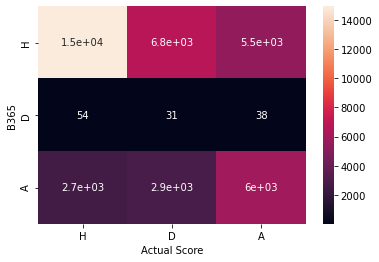

In [76]:
from sklearn.metrics import accuracy_score, confusion_matrix

print('Mean B365 accuracy: {:.2f}'.format(accuracy_score(betting_odds['B365_Pred'], betting_odds['Result_Actual'])))

ax = sns.heatmap(confusion_matrix(betting_odds['B365_Pred'], betting_odds['Result_Actual'],labels=['H','D','A']),xticklabels=['H','D','A'],yticklabels=['H','D','A'],annot=True)  
ax.set_xlabel('Actual Score')
ax.set_ylabel('B365')
plt.show()

In [77]:
confusion_matrix(betting_odds['B365_Pred'], betting_odds['Result_Actual'],labels=['H','D','A'])

array([[14922,  6779,  5493],
       [   54,    31,    38],
       [ 2685,  2914,  5973]], dtype=int64)

Accuracy excluding draws:

In [78]:
accuracy_score(betting_odds[(betting_odds['B365_Pred']!='D')&(betting_odds['Result_Actual']!='D')]['B365_Pred'],\
               betting_odds[(betting_odds['B365_Pred']!='D')&(betting_odds['Result_Actual']!='D')]['Result_Actual'])

0.7187080796615416

## Home matches

In [79]:
H_x = H_stats

In [80]:
H_x.columns

Index(['Last_1_H', 'Last_1', 'Last_3_H', 'Last_3', 'Last_5_H', 'Last_5',
       'Last_1_H_Teams', 'Last_1_Teams', 'Last_3_H_Teams', 'Last_3_Teams',
       'Standing_Pre_Match', 'Last_1_Opp', 'Last_3_Opp', 'Last_5_Opp',
       'Last_1_A_Opp', 'Last_3_A_Opp', 'Last_5_A_Opp',
       'Standing_Pre_Match_vs_Opp'],
      dtype='object')

In [81]:
len(H_x)

30725

In [82]:
H_y = H_metadata['Result']

In [83]:
len(H_y)

30725

In [84]:
H_y.value_counts()

W    13896
L     9187
D     7642
Name: Result, dtype: int64

### Multi-class Classification

Balance multi-class dataset using undersampling

In [85]:
H_x['Results'] = H_y

In [86]:
min_count = H_y.value_counts().min()

H_x_balanced = pd.DataFrame()
for cat in H_x['Results'].unique():
    H_x_cat = H_x[H_x['Results']==cat].sample(min_count)
    H_x_balanced = H_x_balanced.append(H_x_cat)
    
H_x_balanced.reset_index(drop=True, inplace=True)

H_y_balanced = H_x_balanced['Results']
H_x_balanced = H_x_balanced.drop(columns=['Results'])

Try different types of models in their default configuration

In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(H_x_balanced, H_y_balanced, test_size=0.33, random_state=42)

In [88]:
y_train.value_counts()

D    5148
L    5133
W    5079
Name: Results, dtype: int64

Mean accuracy on training set: 0.46
Mean accuracy on test set: 0.45


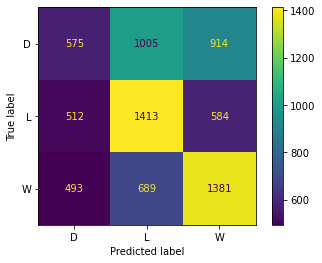

In [89]:
from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf = clf.fit(X_train, y_train)

print('Mean accuracy on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Mean accuracy on test set: {:.2f}'.format(clf.score(X_test, y_test)))

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

Mean accuracy on training set: 0.45
Mean accuracy on test set: 0.44


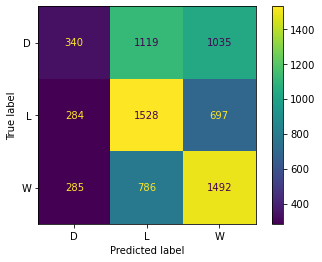

In [90]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=42)
clf = clf.fit(X_train, y_train)

print('Mean accuracy on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Mean accuracy on test set: {:.2f}'.format(clf.score(X_test, y_test)))

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

Mean accuracy on training set: 1.00
Mean accuracy on test set: 0.36


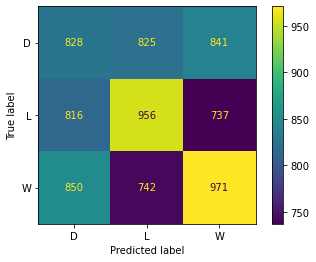

In [91]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf = clf.fit(X_train, y_train)

print('Mean accuracy on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Mean accuracy on test set: {:.2f}'.format(clf.score(X_test, y_test)))

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

In [92]:
# Algorithm spot-check
from sklearn.metrics import fbeta_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

def predictor(classifier, X_train, X_test, y_train, y_test):
    
    # fit the model using the training data
    model = classifier.fit(X_train, y_train)
    
    # make prediction on first 500 samples of training set
    y_pred_train = model.predict(X_train[:500])
    
    # make prediction on test set
    y_pred_test = model.predict(X_test)
    
    # calculate accuracy on training and test set
    accuracy_train = accuracy_score(y_train[:500],y_pred_train)
    accuracy_test = accuracy_score(y_test,y_pred_test)
    
    accuracy = [accuracy_train,accuracy_test]
        
    return accuracy, y_pred_test, y_pred_train

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier

# Dictionary containing all classification models to be tested
models = dict()

models['Logistic'] = LogisticRegression(class_weight='balanced', random_state=42)
models['Decision Tree'] = DecisionTreeClassifier(class_weight='balanced', random_state=42)
models['Linear SVM'] = SVC(kernel='linear', class_weight='balanced', random_state=42)
models['Cubic SVM'] = SVC(kernel='poly', class_weight='balanced', random_state=42)
# for c in np.arange(0.1, 1.1, 0.1):
#     models['RBF SVM (C = '+str(c)+')'] = SVC(C=c, class_weight='balanced', random_state=42)
models['Naive Bayes'] = GaussianNB()
models['Bagging'] = BaggingClassifier(n_estimators=50 ,random_state=42)
models['Random Forest'] = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)
models['Gradient Boosting'] = GradientBoostingClassifier(n_estimators=50 ,random_state=42)
models['AdaBoost'] = AdaBoostClassifier(n_estimators=50 ,random_state=42)

In [94]:
scores = []
recalls = []
accuracies = []

for model in models:
    
    accuracy, y_pred_test, y_pred_train = predictor(models[model], X_train, X_test, y_train, y_test)
    
    accuracies.append(accuracy[1])
    
    print(model)
    print('Accuracy on training set = {:.2f}%'.format(accuracy[0]*100))
    print('Accuracy on test set = {:.2f}%'.format(accuracy[1]*100))
    print('----------------------------------------------')

Logistic
Accuracy on training set = 45.00%
Accuracy on test set = 44.45%
----------------------------------------------
Decision Tree
Accuracy on training set = 100.00%
Accuracy on test set = 37.54%
----------------------------------------------
Linear SVM
Accuracy on training set = 46.20%
Accuracy on test set = 44.85%
----------------------------------------------
Cubic SVM
Accuracy on training set = 47.60%
Accuracy on test set = 43.42%
----------------------------------------------
Naive Bayes
Accuracy on training set = 45.20%
Accuracy on test set = 44.01%
----------------------------------------------
Bagging
Accuracy on training set = 100.00%
Accuracy on test set = 41.90%
----------------------------------------------
Random Forest
Accuracy on training set = 100.00%
Accuracy on test set = 43.29%
----------------------------------------------
Gradient Boosting
Accuracy on training set = 50.20%
Accuracy on test set = 44.25%
----------------------------------------------
AdaBoost
Accu

In [95]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

y_train_one_hot = to_categorical(y_train_encoded)

In [96]:
print(label_encoder.classes_)

['D' 'L' 'W']


In [533]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
#model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu'))
#model.add(Dropout(0.3))


model.add(Dense(100, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))


#model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu'))
#model.add(Dropout(0.3))

#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.3))

#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))


#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(y_train_one_hot.shape[1], activation='softmax'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 100)               1900      
                                                                 
 dropout_21 (Dropout)        (None, 100)               0         
                                                                 
 dense_47 (Dense)            (None, 100)               10100     
                                                                 
 dropout_22 (Dropout)        (None, 100)               0         
                                                                 
 dense_48 (Dense)            (None, 3)                 303       
                                                                 
Total params: 12,303
Trainable params: 12,303
Non-trainable params: 0
_________________________________________________________________


In [534]:
#Callback to plot loss while training
from plot_learning import PlotLearning
plot_learning = PlotLearning()

In [535]:
# compile model
from tensorflow.keras.optimizers import SGD, Adam
opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',optimizer=opt)

C:\Users\akapelet\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


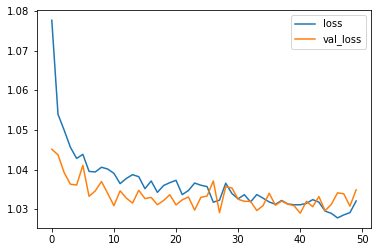

In [536]:
epochs = 50
batch_size = 32

hist = model.fit(X_train, y_train_one_hot, epochs = epochs, batch_size = batch_size, validation_split=0.15,\
                 callbacks=[plot_learning],verbose=0)

In [537]:
y_pred_train = model.predict(X_train) 
y_pred_test = model.predict(X_test)

y_pred_test = label_encoder.inverse_transform(np.argmax(y_pred_test,axis=1))
y_pred_train = label_encoder.inverse_transform(np.argmax(y_pred_train,axis=1))

Neural net accuracy on training set: 46.46%
Neural net accuracy on test set: 44.87%


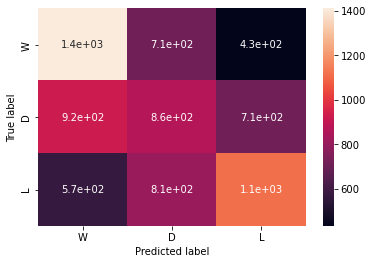

In [538]:
print('Neural net accuracy on training set: {:.2f}%'.format(100*accuracy_score(y_pred_train,y_train)))
print('Neural net accuracy on test set: {:.2f}%'.format(100*accuracy_score(y_pred_test,y_test)))


ax = sns.heatmap(confusion_matrix(y_test, y_pred_test, labels=['W','D','L']),xticklabels=['W','D','L'],yticklabels=['W','D','L'],annot=True)                 
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()

Most of the trouble is in distinguishing draws from wins and loses. We will try training a binary classifier to predict Wins/Losses only. If the probability of win lose is close to 50% (based on a manual threshold), the result will be set to draw. 

# Binary Classification (W/L)

In [495]:
# H_x_binary = H_x[H_x['Results']!='D']

In [279]:
# H_x_binary['Results'].value_counts()

W    13867
L     9169
Name: Results, dtype: int64

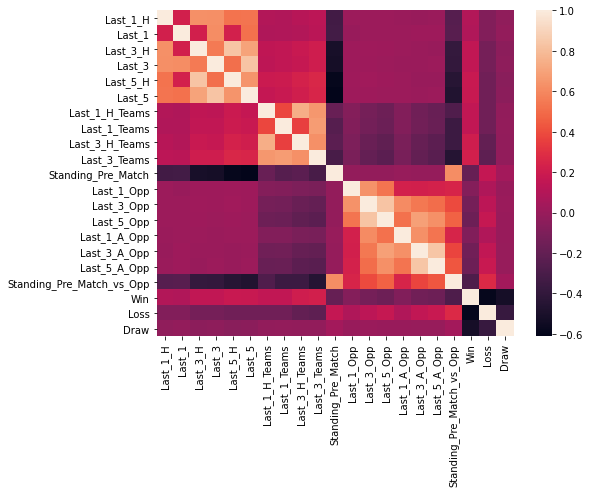

In [326]:
import seaborn as sns

X_heatmap = H_x.copy()
X_heatmap.loc[:,'Win'] = X_heatmap['Results'].apply(lambda x: 1 if x=='W' else 0)
X_heatmap.loc[:,'Loss'] = X_heatmap['Results'].apply(lambda x: 1 if x=='L' else 0)
X_heatmap.loc[:,'Draw'] = X_heatmap['Results'].apply(lambda x: 1 if x=='D' else 0)

fig = plt.figure(figsize=(8, 6))
sns.heatmap(X_heatmap.corr())
plt.show()

In [327]:
# Select features that we want to not use in the prediction 
to_drop = []
#to_drop = ['Last_5_H', 'Last_5','Last_5_Opp','Last_5_A_Opp']
H_x_reduced = H_x.drop(columns=to_drop)

In [328]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(H_x_reduced.drop(columns='Results'), H_y, test_size=0.33, random_state=42)

In [329]:
def balance_undersample(x, y):
    x = x.copy()
    x['Results'] = y
    
    min_count = x['Results'].value_counts().min()

    x_balanced = pd.DataFrame()
    for cat in x['Results'].unique():
        x_cat = x[x['Results']==cat].sample(min_count)
        x_balanced = x_balanced.append(x_cat)
    
    x_balanced.reset_index(drop=True, inplace=True)

    y_balanced = x_balanced['Results']
    x_balanced = x_balanced.drop(columns=['Results'])
    
    return x_balanced, y_balanced

In [330]:
def convert_to_binary(x,y,classes_drop):
    x = x.copy()
    x['Results'] = y
    
    x_binary = x[~x['Results'].isin(classes_drop)]
    
    y_binary = x_binary['Results']
    x_binary = x_binary.drop(columns=['Results'])
    
    return x_binary, y_binary

In [331]:
X_train, y_train = convert_to_binary(X_train, y_train, classes_drop=['D'])
X_train, y_train = balance_undersample(X_train, y_train)

In [332]:
y_train.value_counts()

W    6160
L    6160
Name: Results, dtype: int64

In [333]:
def binary_to_triclass_prediction(pred, pred_probs, thres):
    pred_adj = pred.copy()
    for i, proba in enumerate(pred_probs):
        if np.abs(proba[0]-0.5) <= thres:
            pred_adj[i] = 'D'
    return pred_adj

In [334]:
from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf = clf.fit(X_train, y_train)

print('Mean accuracy on training set (biclass): {:.2f}'.format(clf.score(X_train, y_train)))

X_test_binary, y_test_binary = convert_to_binary(X_test, y_test, classes_drop=['D'])
print('Mean accuracy on test set (biclass): {:.2f}'.format(clf.score(X_test_binary, y_test_binary)))
plot_confusion_matrix(clf, X_test_binary, y_test_binary)  
plt.show()

# Prediction on test set with 3 classes
y_pred_test = binary_to_triclass_prediction(clf.predict(X_test), clf.predict_proba(X_test), thres=0.05)

print('Mean accuracy on test set: {:.2f}'.format(accuracy_score(y_pred_test, y_test)))

ax = sns.heatmap(confusion_matrix(y_test, y_pred_test, labels=['W','D','L']),xticklabels=['W','D','L'],yticklabels=['W','D','L'],annot=True)                 
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()


ValueError: could not convert string to float: 'Panathinaikos_Atromitos_2021-12-11'

Mean accuracy on training set (biclass): 0.66
Mean accuracy on test set (biclass): 0.67


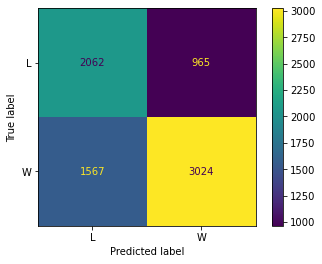

Mean accuracy on test set: 0.49


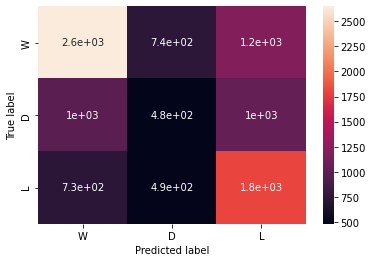

In [106]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

clf = CalibratedClassifierCV(LinearSVC(random_state=42)) 
clf = clf.fit(X_train, y_train)

print('Mean accuracy on training set (biclass): {:.2f}'.format(clf.score(X_train, y_train)))

X_test_binary, y_test_binary = convert_to_binary(X_test, y_test, classes_drop=['D'])
print('Mean accuracy on test set (biclass): {:.2f}'.format(clf.score(X_test_binary, y_test_binary)))
plot_confusion_matrix(clf, X_test_binary, y_test_binary)  
plt.show()

# Prediction on test set with 3 classes
y_pred_test = binary_to_triclass_prediction(clf.predict(X_test), clf.predict_proba(X_test), thres=0.05)

print('Mean accuracy on test set: {:.2f}'.format(accuracy_score(y_pred_test, y_test)))

ax = sns.heatmap(confusion_matrix(y_test, y_pred_test, labels=['W','D','L']),xticklabels=['W','D','L'],yticklabels=['W','D','L'],annot=True)                 
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()


Mean accuracy on training set (biclass): 1.00
Mean accuracy on test set (biclass): 0.58


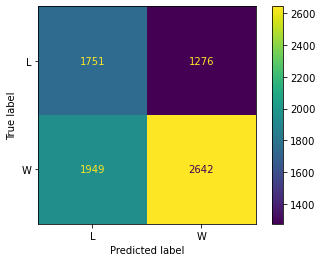

Mean accuracy on test set: 0.43


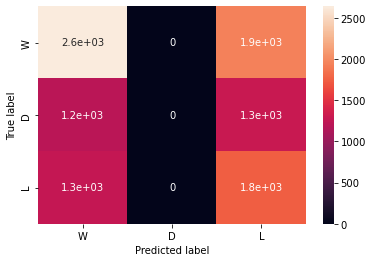

In [107]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf = clf.fit(X_train, y_train)

print('Mean accuracy on training set (biclass): {:.2f}'.format(clf.score(X_train, y_train)))

X_test_binary, y_test_binary = convert_to_binary(X_test, y_test, classes_drop=['D'])
print('Mean accuracy on test set (biclass): {:.2f}'.format(clf.score(X_test_binary, y_test_binary)))
plot_confusion_matrix(clf, X_test_binary, y_test_binary)  
plt.show()

# Prediction on test set with 3 classes
y_pred_test = binary_to_triclass_prediction(clf.predict(X_test), clf.predict_proba(X_test), thres=0.05)

print('Mean accuracy on test set: {:.2f}'.format(accuracy_score(y_pred_test, y_test)))

ax = sns.heatmap(confusion_matrix(y_test, y_pred_test, labels=['W','D','L']),xticklabels=['W','D','L'],yticklabels=['W','D','L'],annot=True)                 
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()


In [108]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

y_train_one_hot = to_categorical(y_train_encoded)

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.3))


# model.add(Dense(100, input_shape=(X_train.shape[1],), activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.5))



model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))


#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(y_train_one_hot.shape[1], activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                608       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 2

In [710]:
#Callback to plot loss while training
from plot_learning import PlotLearning
plot_learning = PlotLearning()

In [711]:
# compile model
from tensorflow.keras.optimizers import SGD, Adam
opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',optimizer=opt)

C:\Users\akapelet\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


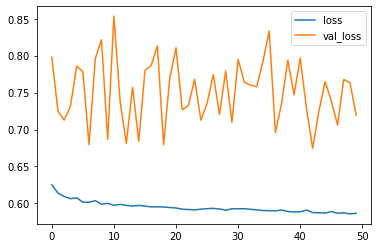

In [712]:
epochs = 50
batch_size = 16

hist = model.fit(X_train, y_train_one_hot, epochs = epochs, batch_size = batch_size, validation_split=0.15,\
                 callbacks=[plot_learning],verbose=0)

In [697]:
y_pred_train = model.predict(X_train) 
y_pred_test = model.predict(X_test)

y_pred_test = label_encoder.inverse_transform(np.argmax(y_pred_test,axis=1))
y_pred_train = label_encoder.inverse_transform(np.argmax(y_pred_train,axis=1))

Neural net accuracy on training set: 65.71%
Neural net accuracy on test set: 50.65%


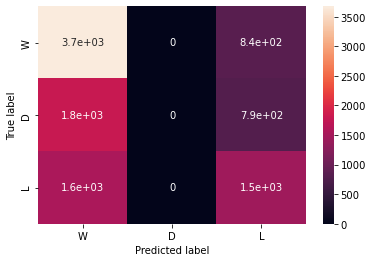

In [698]:
print('Neural net accuracy on training set: {:.2f}%'.format(100*accuracy_score(y_pred_train,y_train)))
print('Neural net accuracy on test set: {:.2f}%'.format(100*accuracy_score(y_pred_test,y_test)))


ax = sns.heatmap(confusion_matrix(y_test, y_pred_test, labels=['W','D','L']),xticklabels=['W','D','L'],yticklabels=['W','D','L'],annot=True)                 
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()

TODO:
- Play a bit more with neural net in bi-class case
- Combine Home and Away predictors to get overall match prediction

# Home & Away models combined

In [348]:
H_x = H_stats.copy()
A_x = A_stats.copy()

In [349]:
H_metadata.loc[:,'id'] = H_metadata.loc[:,'Team'] + "_" + H_metadata.loc[:,'Opponent'] + "_" + H_metadata.loc[:,'Date'].dt.strftime("%Y-%m-%d")
H_x['id'] = H_metadata['id']

C:\Users\akapelet\Anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [350]:
A_metadata.loc[:,'id'] = A_metadata.loc[:,'Opponent'] + "_" + A_metadata.loc[:,'Team'] + "_" + A_metadata.loc[:,'Date'].dt.strftime("%Y-%m-%d")
A_x['id'] = A_metadata['id']

In [351]:
import random
def sample_test_ids(id_list, test_size=0.33):
    random.seed(42)
    test_ids = random.sample(id_list, int(len(id_list)*test_size))
    return test_ids

In [352]:
H_x['Results'] = H_metadata['Result']

In [353]:
X_train = H_x[~H_x['id'].isin(test_ids)]
X_test = H_x[H_x['id'].isin(test_ids)]

y_train = X_train['Results']
y_test = X_test['Results']

X_train = X_train.drop(columns=['Results','id'])
X_test = X_test.drop(columns=['Results','id'])

In [354]:
y_train.value_counts()

W    9319
L    6112
D    5155
Name: Results, dtype: int64

In [355]:
def prepare_data_for_pred(X, y, test_ids, binarise=True, balance=True,to_drop=[]):
    from sklearn.model_selection import train_test_split

    X_reduced = X.drop(columns=to_drop)
    
    X_reduced['Results'] = y['Result']
    
    # Train-test split
    X_train = X_reduced[~X_reduced['id'].isin(test_ids)]
    X_test = X_reduced[X_reduced['id'].isin(test_ids)]

    y_train = X_train['Results']
    y_test = X_test[['id','Results']]

    X_train = X_train.drop(columns=['Results','id'])
    X_test = X_test.drop(columns=['Results'])
        
    if binarise:
        X_train, y_train = convert_to_binary(X_train, y_train, classes_drop=['D'])
    if balance:
        X_train, y_train = balance_undersample(X_train, y_train)

    return X_train, X_test, y_train, y_test

In [356]:
from sklearn.linear_model import LogisticRegression

# Get ids of matches used for training and testing
all_ids = list(set(H_metadata['id']).intersection(set(A_metadata['id'])))
test_ids = sample_test_ids(all_ids, test_size=0.33)

# Home model
H_x_train, H_x_test, H_y_train, H_y_test = prepare_data_for_pred(H_x, H_metadata, test_ids=test_ids, binarise=True, balance=True,to_drop=[]) 
H_clf = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf = clf.fit(H_x_train, H_y_train)

# Away model
A_x_train, A_x_test, A_y_train, A_y_test = prepare_data_for_pred(A_x, A_metadata, test_ids=test_ids, binarise=True, balance=True,to_drop=[]) 
H_clf = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf = clf.fit(A_x_train, A_y_train)

In [362]:
H_predictions_test = pd.DataFrame()
H_predictions_test['id'] = H_x_test['id']
H_predictions_test['pred'] = clf.predict(H_x_test.drop(columns=['id']))
H_predictions_test['pred_proba'] = [max(i) for i in clf.predict_proba(H_x_test.drop(columns=['id']))]

H_predictions_test['pred'] = H_predictions_test['pred'].apply(lambda x: 'H' if x=='W' else 'A')

In [363]:
H_predictions_test

,id,pred,pred_proba
2,Hibernian_St Mirren_2010-01-30,H,0.763701
4,Rangers_Falkirk_2010-01-30,H,0.865335
7,St Mirren_St Johnstone_2010-02-10,A,0.561792
9,Falkirk_Kilmarnock_2010-02-10,H,0.537506
12,Aberdeen_Celtic_2010-02-13,A,0.682775
...,...,...,...
30712,Panathinaikos_Atromitos_2021-12-11,H,0.786713
30715,PAOK_Lamia_2021-12-12,H,0.837211
30719,Giannina_PAOK_2021-12-15,A,0.582741
30721,Panetolikos_Atromitos_2021-12-18,H,0.541985


In [367]:
A_predictions_test = pd.DataFrame()
A_predictions_test['id'] = A_x_test['id']
A_predictions_test['pred'] = clf.predict(A_x_test.drop(columns=['id']))
A_predictions_test['pred_proba'] = [max(i) for i in clf.predict_proba(A_x_test.drop(columns=['id']))]

A_predictions_test['pred'] = A_predictions_test['pred'].apply(lambda x: 'A' if x=='W' else 'H')

In [368]:
A_predictions_test

,id,pred,pred_proba
3,Hibernian_St Mirren_2010-01-30,H,0.751772
5,Rangers_Falkirk_2010-01-30,H,0.827981
7,Falkirk_Kilmarnock_2010-02-10,H,0.563569
10,St Mirren_St Johnstone_2010-02-10,A,0.618711
13,Kilmarnock_St Johnstone_2010-02-13,H,0.523799
...,...,...,...
30713,Panathinaikos_Atromitos_2021-12-11,H,0.753564
30714,PAOK_Lamia_2021-12-12,H,0.750957
30719,Giannina_PAOK_2021-12-15,A,0.653590
30721,Panetolikos_Atromitos_2021-12-18,A,0.501200


In [372]:
predictions_test = H_predictions_test.merge(A_predictions_test, on=['id']).rename(columns={'pred_x':'pred_H', 'pred_proba_x':'pred_proba_H',\
                                                                                            'pred_y':'pred_A', 'pred_proba_y':'pred_proba_A'})

In [374]:
predictions_test['pred_Combined'] = predictions_test[['pred_H','pred_A']].apply(lambda x: x[0] if x[0]==x[1] else 'D', axis=1)

In [379]:
predictions_test['pred_proba_Combined'] = predictions_test[['pred_Combined','pred_proba_H','pred_proba_A']].\
                apply(lambda x: (x[1]+x[2])/2 if x[0] != 'D' else np.nan, axis=1)

In [380]:
predictions_test

,id,pred_H,pred_proba_H,pred_A,pred_proba_A,pred_Combined,pred_proba_Combined
0,Hibernian_St Mirren_2010-01-30,H,0.763701,H,0.751772,H,0.757736
1,Rangers_Falkirk_2010-01-30,H,0.865335,H,0.827981,H,0.846658
2,St Mirren_St Johnstone_2010-02-10,A,0.561792,A,0.618711,A,0.590251
3,Falkirk_Kilmarnock_2010-02-10,H,0.537506,H,0.563569,H,0.550538
4,Aberdeen_Celtic_2010-02-13,A,0.682775,A,0.753088,A,0.717931
...,...,...,...,...,...,...,...
10134,Panathinaikos_Atromitos_2021-12-11,H,0.786713,H,0.753564,H,0.770138
10135,PAOK_Lamia_2021-12-12,H,0.837211,H,0.750957,H,0.794084
10136,Giannina_PAOK_2021-12-15,A,0.582741,A,0.653590,A,0.618166
10137,Panetolikos_Atromitos_2021-12-18,H,0.541985,A,0.501200,D,NaN
